In [1]:
import pandas as pd
import ast
import statistics
import matplotlib.pyplot as plt
import numpy as np
import numpy
import tables
from scipy.stats import spearmanr
from nltk.corpus import cmudict
import nltk.corpus.reader.cmudict
from string import digits
import json
from nltk.tokenize import RegexpTokenizer
from intersection_imagenet_flickr8k import imagenet_flickr8k_intersection,intersection

In [2]:
def iterate_data(h5_file):
    for x in h5_file.root:
        yield x

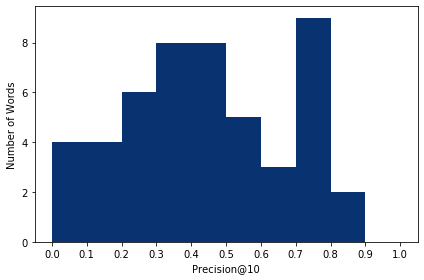

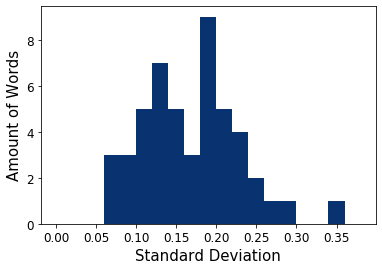

In [3]:
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Results_isolated_word_recognition/results_forcedalignment_49words.csv"

df = pd.read_csv(path)
df["Testedword"] = df["Tested"].str.replace("flickr_","")
df["Testedword"] = [words.split("_")[0] for words in df["Testedword"]]
df["Results"] = [ast.literal_eval(score) for score in df["Results"]]
df["Precision@10"] = [sum(score)*0.1 for score in df["Results"]]

#words tested
testlist = ["dog","man","boy","girl","woman","people"
            ,"dogs","shirt","child","ball","person"
            ,"children","men","girls","bike","rock","camera"
            ,"boys","hat","player","jacket","basketball","swing"
            ,"car", "wall", "hair","football","sunglasses","head"
            ,"shorts","dress","table","water","grass","bench","snow"
            ,"air","field","street","mouth","dirt","mountain","pool"
            ,"ocean","sand","building","soccer","park","face"]

scorelist = pd.DataFrame()

for word in testlist:
    dflength = len(df[df["Testedword"] == word]["Precision@10"])
    averagescore = df[df["Testedword"] == word]["Precision@10"].sum()/dflength
    stdev = statistics.stdev(list(df[df["Testedword"] == word]["Precision@10"]))
    
    valuesdict = {"Word": word, "AvgScore": averagescore, "Stdev": stdev}
    scorelist = scorelist.append(valuesdict, ignore_index=True)

num_bins = 1

fig, ax = plt.subplots()
n, bins, patches = ax.hist(scorelist["AvgScore"], bins = numpy.arange(0, 1.1, 0.1),color="#083370") 
plt.xticks(numpy.arange(0, 1.1, step=0.1))
ax.set_xlabel('Precision@10')
ax.set_ylabel('Number of Words')
ax.set_title(f"")
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
plt.tight_layout()
# plt.savefig('../plots/precision@10testedobjects.png',dpi=1200)

plt.show()

plt.style.use('seaborn-deep')

num_bins = 10
fig, ax = plt.subplots()
n, bins, patches = ax.hist(scorelist["Stdev"], bins = numpy.arange(0, 0.4, 0.02),color="#083370") 
plt.xticks(numpy.arange(0, 0.4, step=0.05))
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Amount of Words')
ax.set_title(f"")

# plt.savefig('/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/plots/stdevtestedobjects.png')

plt.show()

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


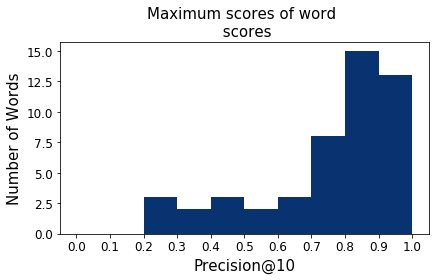

In [4]:
#calculate the highest scores achieved per word
maxscores = pd.DataFrame()
for word in testlist:
    score = df.iloc[df[df["Testedword"]==word]["Precision@10"].idxmax()]["Precision@10"]
    valuesdict = {"Word": word, "maxscore": score}
    maxscores = maxscores.append(valuesdict, ignore_index=True)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(maxscores["maxscore"], bins = numpy.arange(0, 1.1, 0.1),color="#083370") 
plt.xticks(numpy.arange(0, 1.1, step=0.1))
ax.set_xlabel('Precision@10')
ax.set_ylabel('Number of Words')
ax.set_title(f"Maximum scores of word \n scores")
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
plt.tight_layout()
plt.savefig('../plots/maximumscoresprecision@10testedobjects.png',dpi=1200)

numpy.arange(0, 1, 0.1)

scorelist["maxscore"] = np.nan
for idx,word in enumerate(scorelist["Word"]):
    for idx2,words in enumerate(maxscores["Word"]):
        if word == words:
            scorelist["maxscore"][idx] = maxscores["maxscore"][idx2]

In [5]:
scorelist["maxminusavg"] = scorelist["maxscore"] - scorelist["AvgScore"]
scorelist["Stdev"] = scorelist["Stdev"]/2

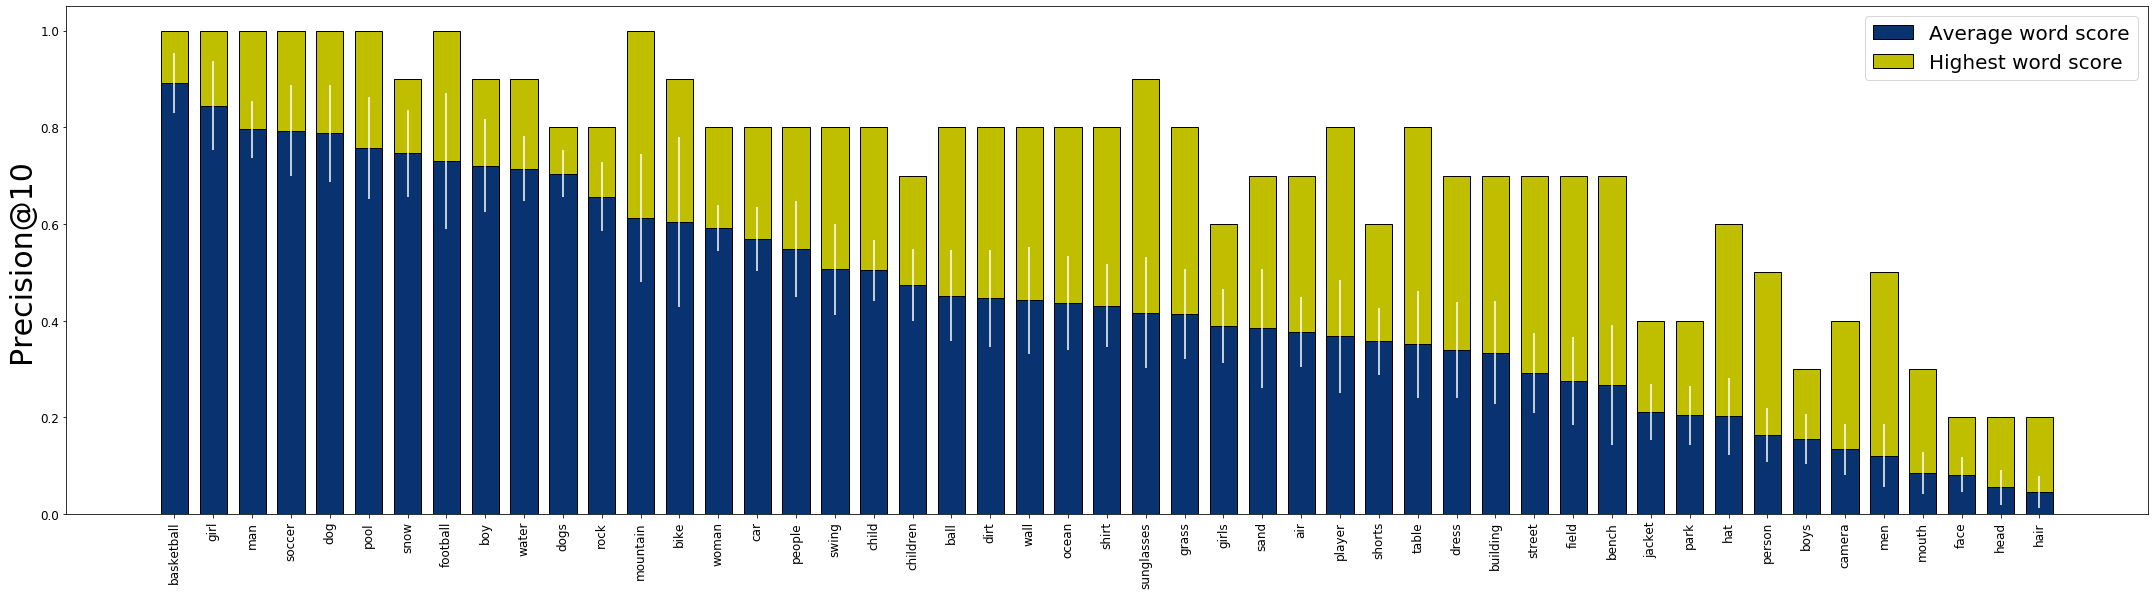

In [6]:
scorelist = scorelist.sort_values(["AvgScore"],ascending=False)

fig, ax = plt.subplots(figsize=(30,8))
barWidth = 0.7
r1 = np.arange(len(scorelist["Word"]))


plt.style.use('seaborn-deep')

plt.rcParams.update({'font.size': 20}) 

plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)

plt.tight_layout()
ax.bar(scorelist["Word"], scorelist["AvgScore"],yerr = scorelist["Stdev"],ecolor = "w", width=barWidth, color='#083370',edgecolor="black", align='center',label="Average word score")
ax.bar(scorelist["Word"], scorelist["maxminusavg"], width=barWidth, color="y",edgecolor="black",align="center",label="Highest word score",bottom=scorelist["AvgScore"])
# plt.xticks([r + barWidth for r in range(len(scorelist["Word"]))], scorelist["Word"])

plt.xticks(rotation=90)
ax.set_ylabel('Precision@10',fontsize=30)
ax.set_title(f"",fontsize=30)
plt.legend()

plt.show()

In [49]:
import torch
path = "files_with_wordembeddings_final.csv"
dfembeddings = pd.read_csv(path)
for idx,embedding in enumerate(dfembeddings["Embedding"]):
#parse scientific data out and interpret string as nparray
    emb = np.array(embedding.replace("\n","").replace("[","").replace("]","").split())
    dfembeddings["Embedding"][idx] = torch.from_numpy(np.array([float(value) for value in emb]))

In [58]:
import torch
def cosine(emb_1, emb_2):
    return torch.matmul(emb_1, emb_2.t())

def results_at_n(embeddings_1,embeddings_2,n):
    results = []
    distances = []
    for index, emb in enumerate(embeddings_1):
        sim = cosine(emb, embeddings_2)
        sorted, indices = sim.sort(descending = True)
        results.append(indices[0:n])
        distances.append(sorted[0:n])
    return results, distances

In [59]:
# for values in dfembeddings["Embedding"]:
#     try:
#         captionembeddings = torch.stack((captionembeddings, values.data))
#     except:
#         captionembeddings = values.data


In [60]:
# dfembeddings[dfembeddings["Word"] == "air"]["Embedding"].sum()/len(dfembeddings[dfembeddings["Word"] == "air"])

In [61]:
dfembeddings["Word"] = [x.split('_')[1] for x in dfembeddings["File"]]
averageembeddings = pd.DataFrame()
dfembeddings[dfembeddings["Word"] == "air"]
#average out the embeddings for words that are tested
for word in testlist:
    #calculate average embedding for a word
    avgembedding = dfembeddings[dfembeddings["Word"] == word]["Embedding"].sum()/len(dfembeddings[dfembeddings["Word"] == word])
    averageembeddings = averageembeddings.append({"Word": word,"Avgembedding":avgembedding},ignore_index=True)

In [77]:
embeddingtensor = torch.stack(tuple(averageembeddings["Avgembedding"]))
results,distances = results_at_n(embeddingtensor,embeddingtensor,6)

averageembeddings["Closestword"] = np.nan

for idx,values in enumerate(results):
    #first value in tensor is most likely word itself so we take the second value, which is the most alike word
    closestword = []
    for val in range(1,len(values)):
        closestword.append(averageembeddings["Word"][int(values[val])])
    averageembeddings["Closestword"][idx] = closestword

averageembeddings["AvgDistance5"] = np.nan
averageembeddings["Distanceclosest"] = np.nan

for idx,values in enumerate(distances):
    #first value in tensor is most likely word itself so we take the second value, which is the most alike word
    averageembeddings["AvgDistance5"][idx] = float(values.sum())/5
    averageembeddings["Distanceclosest"][idx] = float(values[1])


/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

In [78]:
averageembeddings

,Avgembedding,Word,Closestword,AvgDistance5,Distanceclosest
0,"[tensor(-0.0069, dtype=torch.float64), tensor(...",dog,"[dogs, ball, camera, soccer, wall]",0.338545,0.659577
1,"[tensor(0.0072, dtype=torch.float64), tensor(0...",man,"[men, jacket, head, bench, hair]",0.400433,0.610375
2,"[tensor(-0.0206, dtype=torch.float64), tensor(...",boy,"[boys, child, pool, water, wall]",0.401902,0.557236
3,"[tensor(-0.0012, dtype=torch.float64), tensor(...",girl,"[girls, child, children, woman, grass]",0.461998,0.620831
4,"[tensor(-0.0013, dtype=torch.float64), tensor(...",woman,"[girls, girl, wall, boy, water]",0.271405,0.227877
5,"[tensor(-0.0182, dtype=torch.float64), tensor(...",people,"[table, pool, football, children, field]",0.301565,0.333710
6,"[tensor(0.0065, dtype=torch.float64), tensor(-...",dogs,"[dog, ball, soccer, girls, bench]",0.346500,0.659577
7,"[tensor(0.0199, dtype=torch.float64), tensor(0...",shirt,"[shorts, dirt, hair, air, street]",0.431914,0.373302
8,"[tensor(-0.0204, dtype=torch.float64), tensor(...",child,"[girl, children, girls, boy, boys]",0.426193,0.341792
9,"[tensor(-0.0112, dtype=torch.float64), tensor(...",ball,"[wall, basketball, football, soccer, pool]",0.408465,0.386246


In [95]:
cat = []
for values in averageembeddings["Closestword"]:
    for value in values:
        cat.append(value)
cat.count("basketball")
averageembeddings["closenesstoothers"] = np.nan
#count how many times a word occurs in another words top 5 closest embeddings
for idx,word in enumerate(averageembeddings["Word"]):
    averageembeddings["closenesstoothers"][idx] = cat.count(word)
    
averageembeddings=averageembeddings.sort_values(["Distanceclosest"])

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


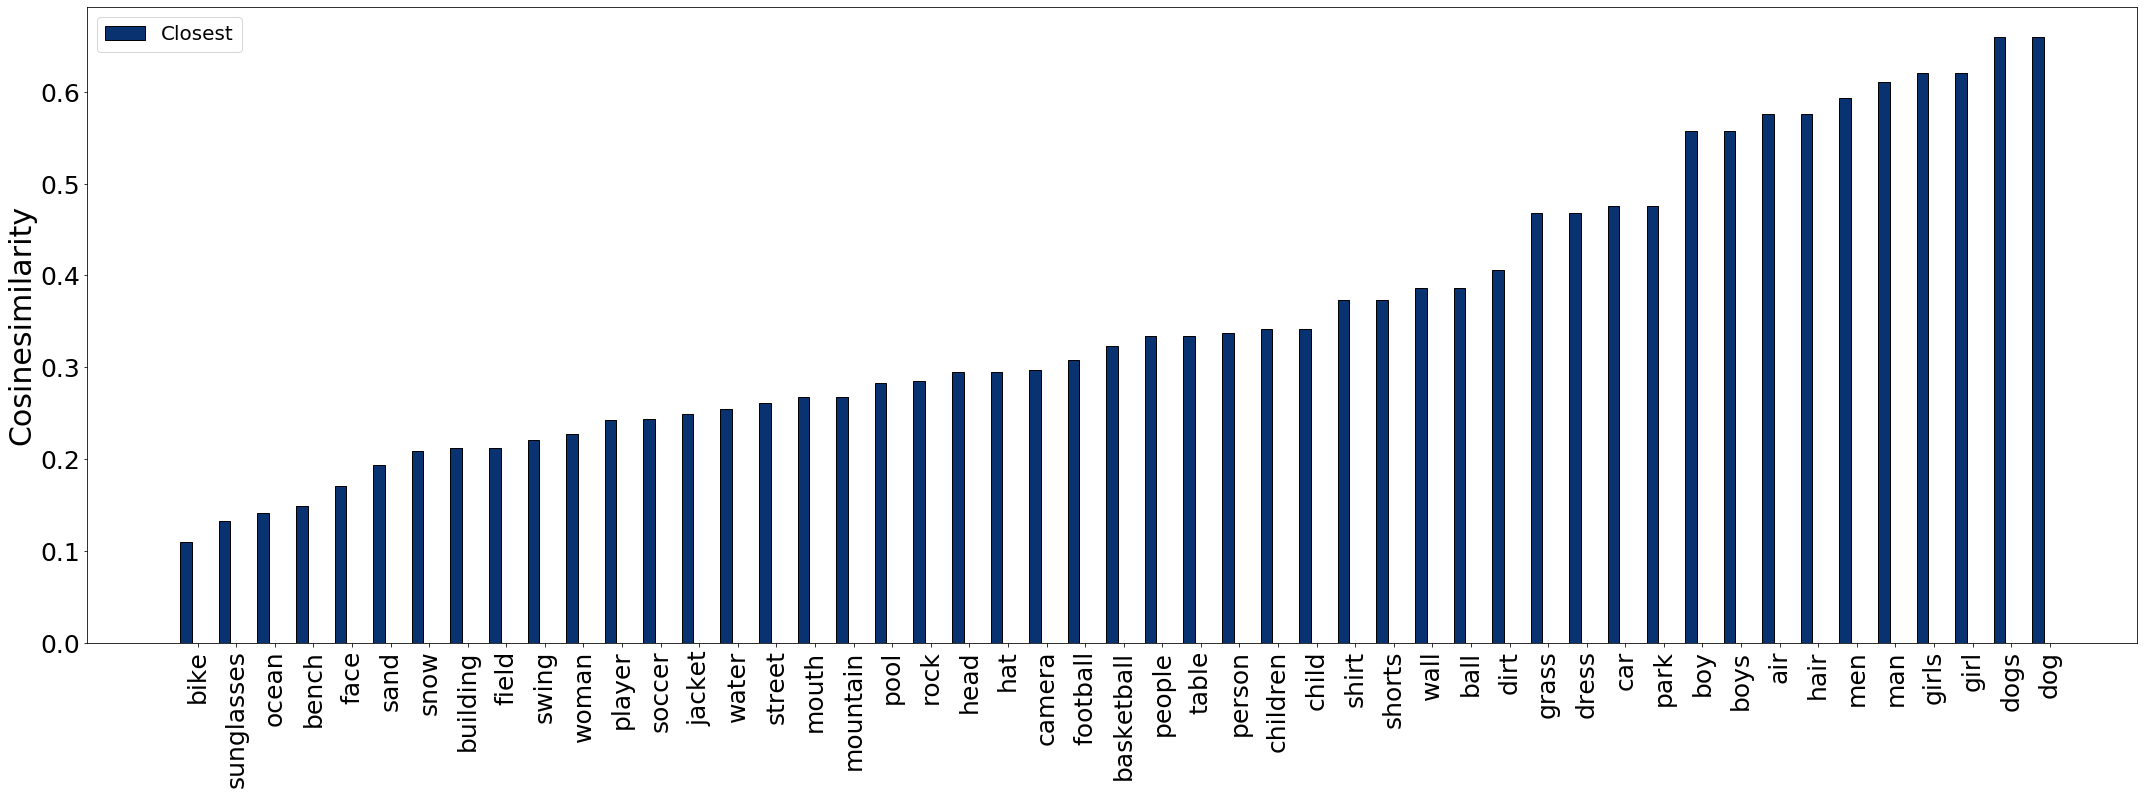

In [97]:
fig, ax = plt.subplots(figsize=(30, 10))
# ax2 = ax.twinx()
barWidth = 0.3
r1 = np.arange(len(averageembeddings["Word"]))
r2 = [x + barWidth for x in r1]

plt.style.use('seaborn-deep')

plt.rcParams.update({'font.size': 20}) 

plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)

plt.tight_layout()
ax.bar(r1, averageembeddings["Distanceclosest"], width=barWidth , color='#083370',edgecolor="black", align='center',label="Closest")
# plt.bar(r2, averageembeddings["AvgDistance5"], width=barWidth,ax=ax2, color='y', edgecolor="black",align='center',label="Avgclosest")


plt.xticks([r + barWidth for r in range(len(averageembeddings["Word"]))], averageembeddings["Word"])
plt.xticks(rotation=90)

ax.set_ylabel('Cosinesimilarity',fontsize=30)
ax.set_title(f"",fontsize=30)

plt.legend()

plt.show()

In [8]:
scorelist = scorelist[['Word',"AvgScore","Stdev"]]
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/Flickr8k_text/Flickr8k.token.txt"
path2 = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/dataset.json"
file = json.load(open(path2))
split_dict = {}
arpabet = nltk.corpus.cmudict.dict()
for x in file['images']:
    split_dict[x['filename'].replace('.jpg', '')] = x['split']
    
trainingset = []
for key, value in split_dict.items():
    if value == "train":
        trainingset.append(key)
text = pd.read_csv(path, sep="\t",header=None)
text.columns = ["images","captions"]
textcopy = text
text.images = [words[:-6] for words in text.images if words==words]
text = text[text.images.isin(trainingset)]

text = text["captions"]
tokenizer = RegexpTokenizer(r'\w+')
wordlist = []
for sentence in text:
    sentence = sentence.lower()
    words = tokenizer.tokenize(sentence)
    wordlist.extend(words)
wordlist = [x.lower() for x in wordlist]
sr = pd.Series(wordlist)
worddictionary = dict(sr.value_counts())


scorelist["WordLength"] = [len(word) for word in scorelist["Word"]]
# scorelist["NSyl"] = [nsyl(word)[0] for word in scorelist["Word"]]
scorelist["TrainingSetOccurence"] = [worddictionary[word] for word in scorelist["Word"]]

path ="/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Generating_Flickrwords_mfcc/mfcc/objects_49words_mfcc_features.h5"

mfccfile = tables.open_file(path, mode="r+")
mfccfile = [node for node in iterate_data(mfccfile)]
wordinstances = pd.DataFrame()

for nodes in mfccfile:
    stringlist = nodes._v_name.split(sep="_")[1:5]
    originalword = nodes._v_name.split(sep="_")[1]
    WordInstance = "_".join(stringlist)
    mfcclength = nodes.mfcc._f_list_nodes()[0].shape[0]
    
    valuesdict = {"WordInstance": WordInstance,"OriginalWord":originalword, "MfccLength": mfcclength}
    wordinstances = wordinstances.append(valuesdict, ignore_index=True)
wordinstances = wordinstances[["WordInstance","OriginalWord","MfccLength"]]

lengthdict = {}
for word in testlist:
    lengthdict[word] = wordinstances[wordinstances["OriginalWord"] == word]["MfccLength"].sum()/len(wordinstances[wordinstances["OriginalWord"] == word])
    
wordinstances["WordAvgMfccLength"] = [lengthdict[word] for word in wordinstances["OriginalWord"]]
for idx,word in enumerate(df["Tested"]):
    stringlist = word.split(sep="_")[1:5]
    joinedword = "_".join(stringlist)
    df["Tested"][idx] = joinedword

wordinstances["Precision@10"] = np.nan

for idx1,string in enumerate(df["Tested"]):
    for idx2,string2 in enumerate(wordinstances["WordInstance"]):
        if string == string2:
            wordinstances["Precision@10"][idx2] = df["Precision@10"][idx1]

scorelist["NofVowels"] = np.nan
scorelist["NofConsonants"] = np.nan

for idx,word in enumerate(scorelist["Word"]):
    vowel = 0
    consonant = 0
    for letter in word:
        if letter in ('a', 'e', 'i', 'o', 'u'):
            vowel = vowel + 1
        else:
            consonant = consonant + 1
    scorelist["NofVowels"][idx] = vowel
    scorelist["NofConsonants"][idx] = consonant

wordinstances["NofPhonemes"] = np.nan
wordinstances["WordLength"] = np.nan
wordinstances['NofVowels'] = np.nan
wordinstances["NofConsonants"] = np.nan

for idx1,string in enumerate(wordinstances["OriginalWord"]):
    remove_digits = str.maketrans('', '', digits)
    x = len([words.translate(remove_digits) for words in arpabet[string][0]])
    wordinstances["NofPhonemes"][idx1] = x 
    for idx2,string2 in enumerate(scorelist["Word"]):
        if string == string2:
            wordinstances["WordLength"][idx1] = scorelist["WordLength"][idx2]
            wordinstances["NofVowels"][idx1] = scorelist["NofVowels"][idx2]
            wordinstances["NofConsonants"][idx1] = scorelist['NofConsonants'][idx2]
            
wordinstances["inimagenet"] = np.nan
imagenet_flickr8k_words = imagenet_flickr8k_intersection()

for idx,word in enumerate(wordinstances["OriginalWord"]):
    if word in imagenet_flickr8k_words:
        wordinstances["inimagenet"][idx] = "1"
        continue
    wordinstances["inimagenet"][idx] = "0"
            
wordinstances["SpeakingSpeed"] = wordinstances["NofPhonemes"] / wordinstances["MfccLength"]
wordinstances.to_csv("wordinstancesdata.csv",index=False)

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
# wordinstances["MfccLengthDeviation"] = wordinstances["MfccLength"] - wordinstances["WordAvgMfccLength"]          
# wordinstances["MfccLengthDeviationNorm"] = wordinstances["MfccLengthDeviation"]/wordinstances["WordAvgMfccLength"]
# coef1,p1 = spearmanr(scorelist["AvgScore"],scorelist["TrainingSetOccurence"])
# coef2,p2 = spearmanr(scorelist["AvgScore"],scorelist["NSyl"])
# coef3,p3 = spearmanr(wordinstances["Precision@10"],wordinstances["MfccLengthDeviationNorm"])
# coef4,p4 = spearmanr(wordinstances["Precision@10"],wordinstances["MfccLength"])
# coef5,p5 = spearmanr(wordinstances["Precision@10"],wordinstances["SpeakingSpeed"])
# coef6,p6 = spearmanr(scorelist["AvgScore"],scorelist["NofConsonants"])
# coef7,p7 = spearmanr(scorelist["AvgScore"],scorelist["NofVowels"])
# coef8,p8 = spearmanr(scorelist["AvgScore"],scorelist["WordLength"])
# print(f"\# of training set occurences & {coef1:.3f} & {p1:.3f} \\\ \hline")
# print(f"\# of syllables & {coef2:.3f} & {p2:.3f} \\\ \hline")
# print(f"\# of consonants & {coef6:.3f} & {p6:.3f}  \\\ \hline")
# print(f"\# number of vowels & {coef7:.3f} & {p7:.3f} \\\ \hline")
# print(f"word length & {coef8:.3f} & {p8:.3f} \\\ \hline")
# print(f"signal length & {coef4:.3f} & {p4:.3f} \\\ \hline")
# print(f"speaking speed & {coef5:.3f} & {p5:.3f} \\\ \hline")
# print(f"\# signal length deviation from word average & {coef3:.3f} & {p3:.3f} \\\ \hline")


In [9]:
wordinstances

,WordInstance,OriginalWord,MfccLength,WordAvgMfccLength,Precision@10,NofPhonemes,WordLength,NofVowels,NofConsonants,inimagenet,SpeakingSpeed
0,air_1311388430_4ab0cd1a1f_1,air,23.0,29.627907,NaN,2.0,6.0,2.0,1.0,0.0,0.086957
1,air_1425069308_488e5fcf9d_0,air,39.0,29.627907,NaN,2.0,6.0,2.0,1.0,0.0,0.051282
2,air_1425069308_488e5fcf9d_3,air,25.0,29.627907,NaN,2.0,6.0,2.0,1.0,0.0,0.080000
3,air_197107117_4b438b1872_4,air,25.0,29.627907,NaN,2.0,6.0,2.0,1.0,0.0,0.080000
4,air_2100816230_ff866fb352_3,air,30.0,29.627907,NaN,2.0,6.0,2.0,1.0,0.0,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
2200,woman_2084217208_7bd9bc85e5_4,woman,34.0,39.567568,NaN,5.0,4.0,2.0,3.0,0.0,0.147059
2201,woman_2086513494_dbbcb583e7_3,woman,35.0,39.567568,NaN,5.0,4.0,2.0,3.0,0.0,0.142857
2202,woman_2086513494_dbbcb583e7_4,woman,33.0,39.567568,NaN,5.0,4.0,2.0,3.0,0.0,0.151515
2203,woman_219301555_17883a51bd_0,woman,45.0,39.567568,NaN,5.0,4.0,2.0,3.0,0.0,0.111111


In [12]:
imagenet_flickr8k_words

['orange',
 'basketball',
 'swing',
 'baseball',
 'sunglasses',
 'suit',
 'cliff',
 'fountain',
 'backpack',
 'pole',
 'jersey',
 'ski',
 'dock',
 'umbrella',
 'restaurant',
 'mask',
 'sweatshirt',
 'tank',
 'canoe',
 'microphone',
 'bikini',
 'stage',
 'bucket',
 'volleyball',
 'cup',
 'racket',
 'racer',
 'balloon',
 'cricket',
 'paddle',
 'ear',
 'fly',
 'hay',
 'unicycle',
 'purse',
 'bubble',
 'chain',
 'muzzle',
 'plate',
 'kite',
 'jeep',
 'parachute',
 'pier',
 'necklace',
 'violin',
 'collie',
 'screen',
 'chest',
 'plane',
 'drum',
 'jean',
 'corn',
 'puck',
 'tricycle',
 'valley',
 'barrel',
 'groom',
 'tiger',
 'bow',
 'patio',
 'pirate',
 'church',
 'apron',
 'pitcher',
 'desk',
 'boxer',
 'pillow',
 'crane',
 'bathtub',
 'beagle',
 'whistle',
 'binoculars',
 'shovel',
 'tripod',
 'barn',
 'snowmobile',
 'wig',
 'tub',
 'pick',
 'flute',
 'bee',
 'laptop',
 'cannon',
 'ambulance',
 'accordion',
 'stove',
 'pot',
 'mouse',
 'library',
 'tractor',
 'pizza',
 'gown',
 'televi